In [253]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# PART 1

In [254]:
df = pd.read_csv("housing.csv")
counts = df['ocean_proximity'].value_counts()


In [255]:
# cleaning the data by removing the nan values and changing data to numerical variables
df['ocean_proximity'] = df['ocean_proximity'].map({'<1H OCEAN':0, 'INLAND':1, 'NEAR OCEAN':2, 'NEAR BAY':3, 'ISLAND':4})
df = df.dropna()

<AxesSubplot:>

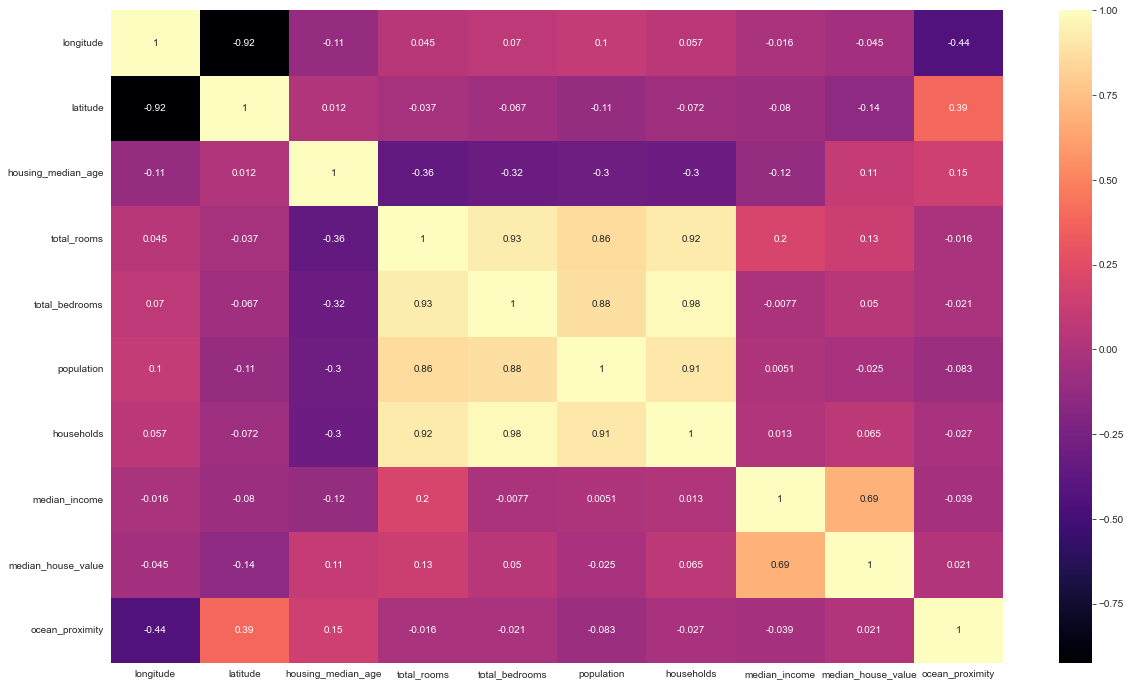

In [256]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(), annot=True, cmap='magma')


The correlation between the variables total rooms, total bedrooms, population, and households is strong, which seems rational and evident.

### • Pick 2 linear regression models to predict median house value


In [257]:
df_1 = df['median_income']
df_1 = np.array(pd.DataFrame(df_1, columns=['median_income'])).reshape(-1, 1)
y = df['median_house_value']
df_2 = df.copy()
df_2 = df_2.drop('median_house_value', axis=1)


### Simple Linear Regression

### Model 1 : Simple (median income)

Text(0.5, 1.0, 'Median Income vs median_house_value')

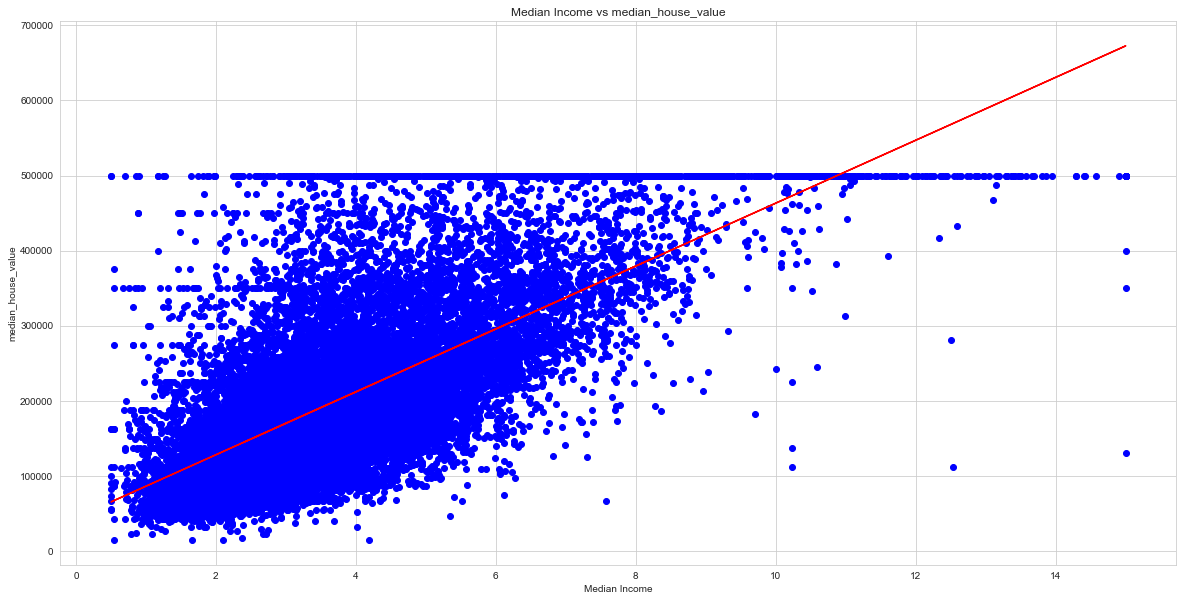

In [258]:
reg = LinearRegression()
reg.fit(df_1, y)
y_pred = reg.predict(df_1)


# plotting the linear regression line for each feature in one plot
plt.figure(figsize=(20, 10))
plt.scatter(df_1, y, color='blue')
plt.plot(df_1, y_pred, color='red')
plt.xlabel('Median Income')
plt.ylabel('median_house_value')
plt.title('Median Income vs median_house_value')


### Multiple Linear Regression (model 2)

The mean squared error is:  4836130919.857883


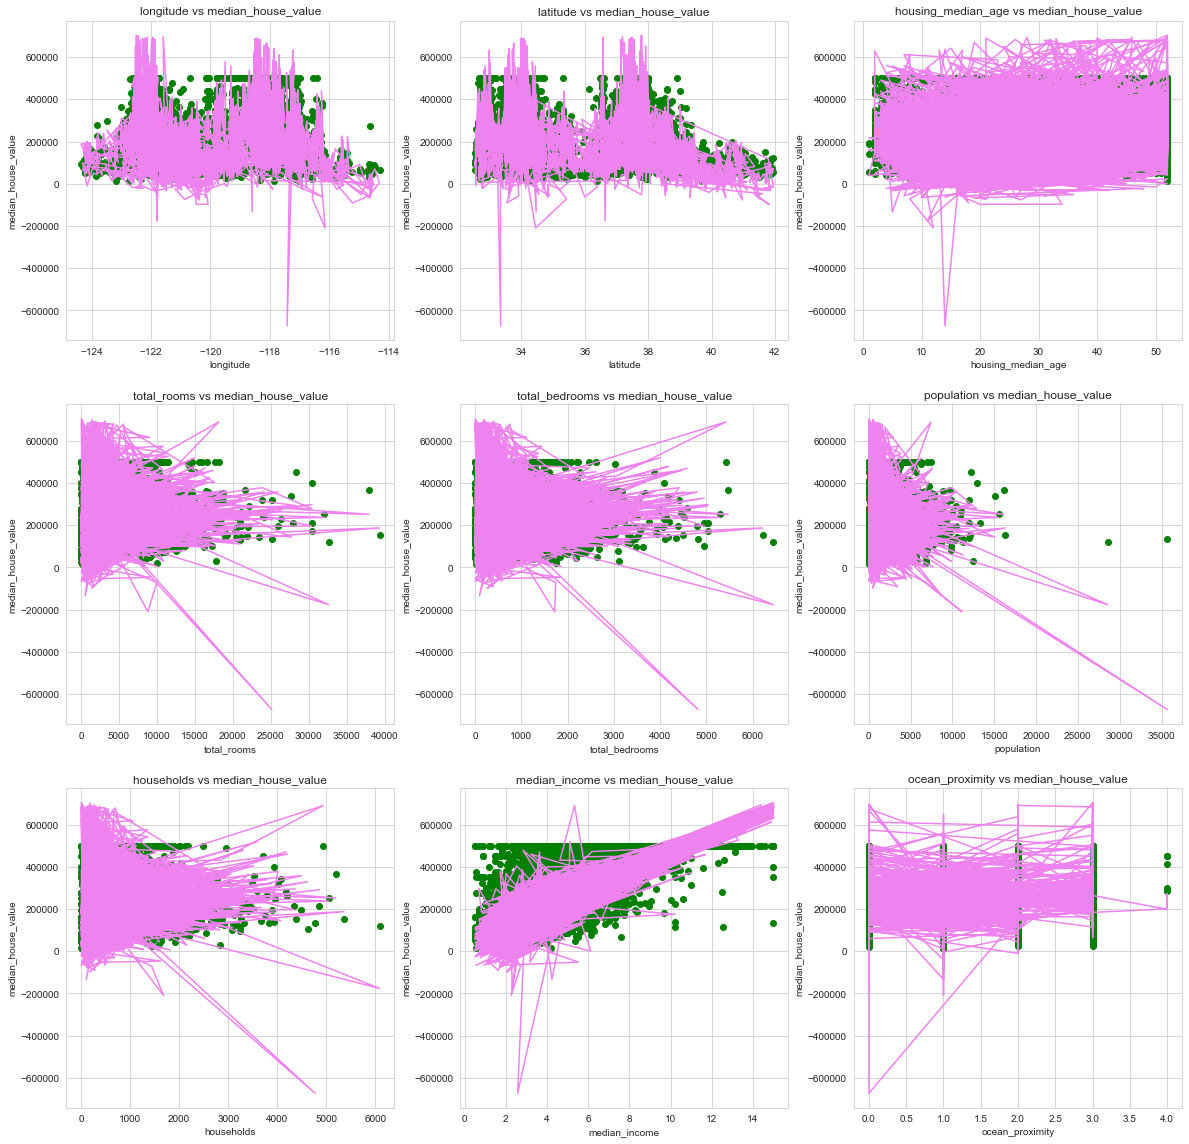

In [259]:
X = df_2
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

mse = mean_squared_error(y_pred, y)
print("The mean squared error is: ", mse)

# plotting the linear regression line for each feature in one plot 
plt.figure(figsize=(20, 20))
for i in range(0, len(df_2.columns)):
    plt.subplot(3, 3, i+1)
    plt.scatter(df_2.iloc[:, i], y, color='green')
    plt.plot(df_2.iloc[:, i], y_pred, color='violet')
    plt.xlabel(df_2.columns[i])
    plt.ylabel('median_house_value')
    plt.title(df_2.columns[i]+' vs median_house_value')


In [260]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = df_2.columns
vif_data["VIF"] = [variance_inflation_factor(df_2.values, i) for i in range(len(df_2.columns))]

In [261]:
X = df_2
for i in range(0,5):
    max_vif_index = vif_data['VIF'].idxmax()
    X = X.drop(vif_data['feature'][max_vif_index], axis=1)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    
df_vif = X
print("The final values are as follows: ")
print(vif_data)


The final values are as follows: 
              feature       VIF
0  housing_median_age  3.343534
1          population  2.060304
2       median_income  3.398471
3     ocean_proximity  1.804031


Text(0.5, 1.0, 'Residuals vs Fitted Values')

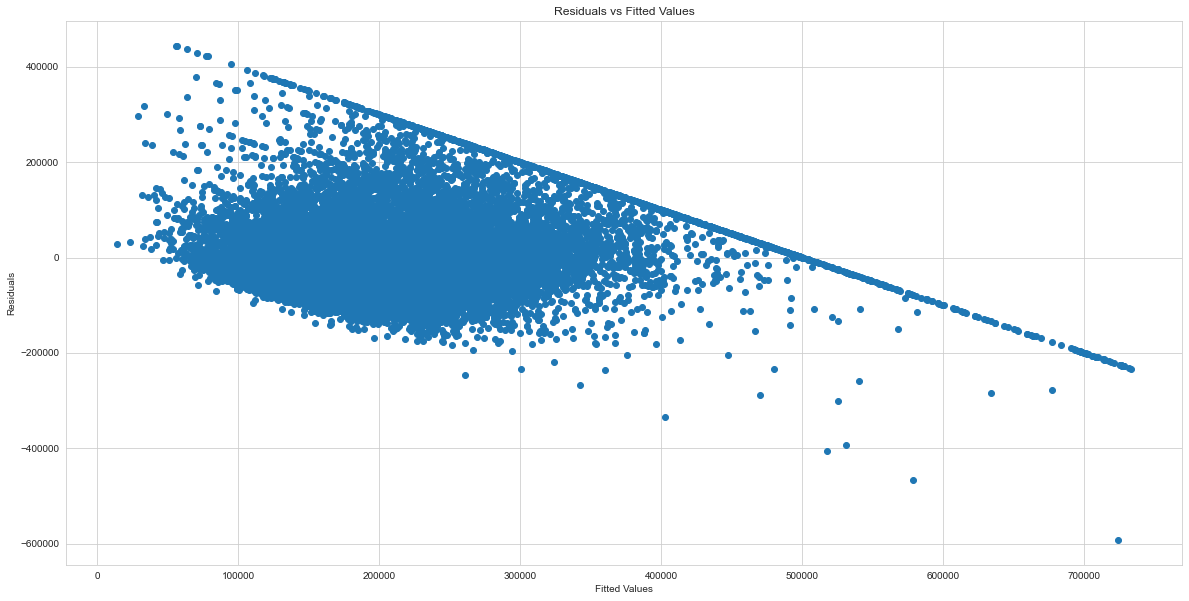

In [262]:
from statsmodels.stats.diagnostic import het_breuschpagan

X = df_vif
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = y - y_pred

plt.figure(figsize=(20, 10))
plt.scatter(y_pred, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')

We get the conclusion that there is no constant variance despite the fact that constant variance is supposed to be necessary for regression because of the uneven distribution of the residuals. Consequently, heteroscedasticity exists. 


In [263]:
bp_test = het_breuschpagan(residuals, X)
print("The p-value of Breusch-Pagan test is: ", bp_test)

The p-value of Breusch-Pagan test is:  (4019.0364330298607, 0.0, 1250.534262418903, 0.0)


Since the p-value for each test is less than 0.05, we may say that the data are heteroscedastic.


In [264]:
X = df_vif
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

residuals = y - y_pred


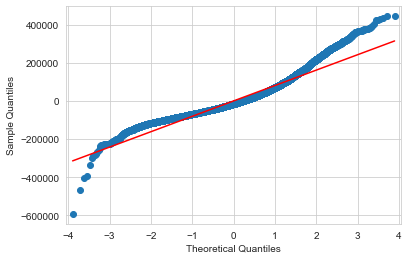

In [265]:
# check for normality using q-q plot
import statsmodels.api as sm
sm.qqplot(residuals, line='s')
plt.show()


As indicated by Q-Q plot, the residuals are not normally distributed

In [266]:
# Comparing the 2 models using AIC and pick the best model

import statsmodels.api as sm

X = df_1
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = y - y_pred

X = df_2
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = y - y_pred

# calculate the AIC for the model with only median income (most correlated)
X = df_1
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.aic)

# calculate the AIC for the model with all the features
X = df_2
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.aic)


521221.80249589926
513649.5908274778


The model with all features has a lower AIC and hence performs better.



In [267]:
import statsmodels.api as sm

X = df_2
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = y - y_pred

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     3983.
Date:                Wed, 26 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:53:12   Log-Likelihood:            -2.5681e+05
No. Observations:               20433   AIC:                         5.136e+05
Df Residuals:                   20423   BIC:                         5.137e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -3.633e+06    6.5

The coefficient of longitude is negative, which means that the median house value decreases as the longitude increases. The coefficient of latitude is positive, which means that the median house value increases as the latitude increases.

# PART 2

In [268]:
#importing the binary csv file and storing it in a dataframe
df_binary = pd.read_csv('binary.csv')
# remove nan values
df_binary = df_binary.dropna()

### part a

In [269]:
# importing the required libraries
import statsmodels.api as sm

X = df_binary.drop('admit', axis=1)
y = df_binary['admit']
X = sm.add_constant(X)

log_reg = sm.Logit(y, X).fit(disp=False)
print(log_reg.params)

y_pred = log_reg.predict(X)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(log_reg.summary())



const   -3.449548
gre      0.002294
gpa      0.777014
rank    -0.560031
dtype: float64
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Wed, 26 Apr 2023   Pseudo R-squ.:                 0.08107
Time:                        23:53:12   Log-Likelihood:                -229.72
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 8.207e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4495      1.133     -3.045      0.002      -5.670      -1.229
gre            0.0023      0.001      2.101 

GPA score is the most important attribute. 2. As a result, we can now exponentiate GPA and forecast whether someone will get admitted.


In [270]:
# exponentiate gpa coef
print(np.exp(log_reg.params[1]))

1.0022965926425997


### part b

In [271]:
import statsmodels.api as sm

X = df_binary.drop('admit', axis=1)
y = df_binary['admit']
X = sm.add_constant(X)
X['gpa_rank'] = X['gpa'] * X['rank']
log_reg = sm.Logit(y, X).fit(disp=False)

# print(log_reg.params)

y_pred = log_reg.predict(X)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(log_reg.summary())


                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      395
Method:                           MLE   Df Model:                            4
Date:                Wed, 26 Apr 2023   Pseudo R-squ.:                 0.08129
Time:                        23:53:12   Log-Likelihood:                -229.67
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 3.188e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3447      2.968     -1.464      0.143     -10.161       1.472
gre            0.0023      0.001      2.104      0.035       0.000       0.004
gpa            1.0367      0.860      1.205      0.2

1. Coefficient of gpa_rank is in between gpa and rank.
2. The influence of gpa on the likelihood of admission varies depending on rank.
For example, the influence of gpa on the chance of admission varies depending on rank.
